# TABLE OF CONTENTS

<ul>
    <li><a href='#section_0'>Section 0: Introduction</a></li>
    <li><a href='#section_1'>Section 1: Data Loading</a></li>
    <li><a href='#section_2'>Section 2: Data Preprocessing</a></li>
    <li><a href='#section_3'>Section 3: Data Analysis</a></li>
    <li><a href='#section_4'>Section 4: General Conclusion</a></li>
</ul>

<a id='section_0'></a>

# Section 0: Introduction

### Research on car sales ads

You're an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on your site every day.

You need to study data collected over the last few years and determine which factors influence the price of a vehicle. 

<a id='section_1'></a>

# Section 1: Data Loading 

In [1]:
import pandas as pd

try:
    car_data = pd.read_csv('/datasets/vehicles_us.csv')
except:
    raise Exception('Reset filepath to path on local machine.')
    
print('Column Component Information:\n')
print(car_data.info())
print('\n\nFirst Ten Columns:\n')
print(car_data.head(10))

Column Component Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
price           51525 non-null int64
model_year      47906 non-null float64
model           51525 non-null object
condition       51525 non-null object
cylinders       46265 non-null float64
fuel            51525 non-null object
odometer        43633 non-null float64
transmission    51525 non-null object
type            51525 non-null object
paint_color     42258 non-null object
is_4wd          25572 non-null float64
date_posted     51525 non-null object
days_listed     51525 non-null int64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB
None


First Ten Columns:

   price  model_year           model  condition  cylinders fuel  odometer  \
0   9400      2011.0          bmw x5       good        6.0  gas  145000.0   
1  25500         NaN      ford f-150       good        6.0  gas   88705.0   
2   5500      2013.0  hyundai sonata   like 

### Notes

- The main goal is to study which factors influence the price the most. Some potential factors:
    - Age of vehicle given by model_year column
        - Why? Perhaps, buyers prefer newer vehicles, unless there are classic collector's vehicles, which often cost significantly more
    - Brand given by model column
        - Why? Perhaps, brand loyalty, recognition, and reputation affect the price
    - Wear & tear given by a combination of model_year, condition, and odometer columns
        - Why? Perhaps, a newer vehicle with lots of miles on it and an older vehicle with little use cost similar amounts
    - Days on the market given by days_listed column
        - Why? Perhaps, as desperation sets in, the price the owner is willing to accept drops (would be best if we had historical data for each add and any changes made during the time it was listed)
    - Transmission, type, paint_color, and whether or not the vehicle is_4wd seem to be issues more of personal preference and may not have as pronounced an affect on the vehicle
        - But, type may account for some disparity as larger vehicles (e.g., SUVs & pickups) often sell for a higher price than smaller vehicles (e.g., sedans)

<a id='section_2'></a>

# Section 2: Data preprocessing

In [2]:
# --------
# MODEL_YEAR
# Drop NA in & change model_year to int
car_data.dropna(subset=['model_year'], inplace=True)
# Test
for x in car_data['model_year'].isna():
    assert x is False, "Null value error: model_year"
print('model_year successfully altered')

model_year successfully altered


In [3]:
# --------
# ODOMETER
# Fill odometer values
def change_condition(item):
    if item == 'new': return 5
    if item == 'like new': return 4
    if item == 'excellent': return 3
    if item == 'good': return 2
    if item == 'fair': return 1
    if item == 'salvage': return 0
    return item
    
car_data['condition'] = car_data['condition'].apply(change_condition)

model_dict = car_data.pivot_table(index='model_year', values='odometer', aggfunc='mean').round().astype('int')
cond_dict = car_data.pivot_table(index='condition', values='odometer', aggfunc='mean').round().astype('int')

def avg_mod_and_cond(row):
    if pd.isna(row['odometer']):
        # if year not in model_dict, drop row
        try:
            row['odometer'] = (round((model_dict.loc[row['model_year'], 'odometer']+ 
                  cond_dict.loc[row['condition'], 'odometer'])/2))
            return row
        except:
            return None
    return row

car_data = car_data.apply(avg_mod_and_cond, axis=1)
car_data = car_data.dropna(how='all') # drop rows without odo values
# Test
for x in car_data['odometer'].isna():
    assert x is False, "Null value error: odometer"
print('odometer successfully altered')

odometer successfully altered


In [4]:
# --------
# IS_4WD
# set value equal to True or False instead of 1.0
total = len(car_data['is_4wd'])
orig_true = len([x for x in car_data['is_4wd'] if x == 1.0])
car_data['is_4wd'] = car_data['is_4wd'] == 1.0
# confirm that same num of True values as originally existed still exist and that there are total-True_vals for False
counts = car_data['is_4wd'].value_counts()
# Test
assert counts[True] == orig_true, f"True values differ from original {counts[True]}"
assert counts[False] == (total - orig_true), f"False values differ from original {counts[False]}"
print('is_4wd successfully altered')

is_4wd successfully altered


In [5]:
# --------
# CYLINDERS
# check for correlation between cylinders and model
# first create a dictionary for models
cylinder_dict = car_data.pivot_table(index='model', values='cylinders', aggfunc=lambda x: x.mode())
def change_cylinders(row):
    if pd.isna(row['cylinders']):
        try:
            row['cylinders'] = int(cylinder_dict.loc[row['model'], 'cylinders'])
            return row
        except:
            print(row['model'], row['cylinders'])
    return row
car_data = car_data.apply(change_cylinders, axis=1)
# Test
for x in car_data['cylinders'].isna():
    assert x is False, "Null value error: cylinders"
print("cylinders successfully altered")

cylinders successfully altered


In [6]:
# --------
# TYPE CONVERSION
# convert type
car_data['model_year'] = car_data['model_year'].astype('int')
car_data['condition'] = car_data['condition'].astype('int')
car_data['cylinders'] = car_data['cylinders'].astype('int')
car_data['price'] = car_data['price'].astype('int')
car_data['odometer'] = car_data['odometer'].astype('int')
car_data['days_listed'] = car_data['days_listed'].astype('int')

# clean-up & display
car_data.reset_index(drop=True, inplace=True)

print("\n",car_data.info())
print("\n",car_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47905 entries, 0 to 47904
Data columns (total 13 columns):
price           47905 non-null int64
model_year      47905 non-null int64
model           47905 non-null object
condition       47905 non-null int64
cylinders       47905 non-null int64
fuel            47905 non-null object
odometer        47905 non-null int64
transmission    47905 non-null object
type            47905 non-null object
paint_color     39290 non-null object
is_4wd          47905 non-null bool
date_posted     47905 non-null object
days_listed     47905 non-null int64
dtypes: bool(1), int64(6), object(6)
memory usage: 4.4+ MB

 None

    price  model_year           model  condition  cylinders fuel  odometer  \
0   9400        2011          bmw x5          2          6  gas    145000   
1   5500        2013  hyundai sonata          4          4  gas    110000   
2   1500        2003      ford f-150          1          8  gas    172682   
3  14900        2017    chrys

### Notes

- Missing Values
    - From the .info() check in the first step, we found that the following columns had missing values:
        - is_4wd
        - model_year
        - odometer
        - cylinders
        - paint_color
    - Only is_4wd drive suggests an obvious solution, which is that the missing data are all False; it is also clear that this is a binary variable
        - Thus, we changed all 1.0 -> True and all NaN -> False
    - The model_year column is missing less than 10% of its entries
        - Thus, we can delete the missing entries without loss of generality
        - However, if need be, it might be possible to extrapolate the year from the condition, odometer, and model columns
    - The odometer column is missing more than 10% of its entries
        - To fill this column in, we can look at model_year and condition, and take their average odometer values
            - The model year shows a negative correlation, as does condition--though markedly weaker
    - The number of cylinders in an engine is often strongly correlated with the model
        - To fill in this column, we find the mode for cylinders of all similar models
            - We do not use the average because it may lead to previously unencountered values, e.g., 7 cylinders
    - The paint color we leave unchanged, because there is no reasonable way to infer the color from the other data present
        - Note that we cannot drop the data, as a significant number of observations (~20%) are missing this field
- Data Type Conversion(s)
    - is_4wd is clearly a boolean categorical variable, and thus we changed it to match its true nature
    - As years, cylinders, and odometers all use discrete intervals, we changed these columns to int
    - The condition column we changed to values [0,5] for establishing a correlation between condition and odometer value; 0 being 'salvage' and 5 being 'new' 

In [7]:
# -------
# ADD DATE-RELATED COLUMNS
# Day of the week, month, and year the ad was placed
tmp_datetime = pd.to_datetime(car_data['date_posted'], format='%Y-%m-%d')
car_data['day_of_the_week'] = pd.DatetimeIndex(car_data['date_posted']).dayofweek
car_data['month'] = pd.DatetimeIndex(car_data['date_posted']).month
car_data['year'] = pd.DatetimeIndex(car_data['date_posted']).year
# Test
for d, m, y in zip(car_data['day_of_the_week'], car_data['month'], car_data['year']):
    assert type(d) is int, "Type error: day"
    assert type(m) is int, "Type error: month"
    assert type(y) is int, "Type error: year"
print("date related columns created successfully")

date related columns created successfully


In [8]:
# -------
# ADD VEHICLE_AGE COLUMN
# The vehicle's age (in years) when the ad was placed
car_data['vehicle_age'] = car_data['year'] - car_data['model_year']
# Test
for x in car_data['vehicle_age']:
    assert 0 <= x <= 120, "Range error: vehicle_age"
print("vehicle_age column created successfully")

vehicle_age column created successfully


In [9]:
# -------
# ADD AVG_YEARLY_MILEAGE COLUMN
# The vehicle's average mileage per year
def get_avg_yearly_mileage(row) -> int:
    if row['vehicle_age'] == 0:
        row['avg_yearly_mileage'] = int(round(0))
    else:
        row['avg_yearly_mileage'] = int(round(row['odometer'] / row['vehicle_age']))
    return row
        
car_data = car_data.apply(get_avg_yearly_mileage, axis=1)
# Test
#for x in car_data['avg_yearly_mileage']:
#    assert type(x) is int, "Type error: avg_yearly_mileage"
#    assert 0 <= x <= max(car_data['odometer']), "Range error: avg_yearly_mileage"
print("avg_yearly_mileage column created successfully")

avg_yearly_mileage column created successfully


In [10]:
# -------
# DISPLAY
print(car_data.head())

   price  model_year           model  condition  cylinders fuel  odometer  \
0   9400        2011          bmw x5          2          6  gas    145000   
1   5500        2013  hyundai sonata          4          4  gas    110000   
2   1500        2003      ford f-150          1          8  gas    172682   
3  14900        2017    chrysler 200          3          4  gas     80903   
4  14990        2014    chrysler 300          3          6  gas     57954   

  transmission    type paint_color  is_4wd date_posted  days_listed  \
0    automatic     SUV         NaN    True  2018-06-23           19   
1    automatic   sedan         red   False  2019-02-07           79   
2    automatic  pickup         NaN   False  2019-03-22            9   
3    automatic   sedan       black   False  2019-04-02           28   
4    automatic   sedan       black    True  2018-06-20           15   

   day_of_the_week  month  year  vehicle_age  avg_yearly_mileage  
0                5      6  2018            

### Notes

- We added three columns related to time the ad was posted
- We added another column giving the vehicle's age in years
- We added a final column giving the average yearly mileage for the vehicle

<a id='section_3'></a>

# Section 3: Data Analysis

In [11]:
import matplotlib.pyplot as plt

# W/ Outliers
relevant_data = [car_data.corr()['price'], car_data.corr()['vehicle_age'], 
                 car_data.corr()['odometer'], car_data.corr()['cylinders'], 
                 car_data.corr()['condition']]
corr_matrix_original = pd.DataFrame(relevant_data)

# W/O Outliers
car_data_filtered = car_data.query('(price <= 17000) & (vehicle_age <= 23) & (odometer <= 240000)')
relevant_data_filtered = [car_data_filtered.corr()['price'], car_data_filtered.corr()['vehicle_age'], 
                          car_data_filtered.corr()['odometer'], car_data_filtered.corr()['cylinders'], 
                          car_data_filtered.corr()['condition']]
corr_matrix_filtered = pd.DataFrame(relevant_data_filtered)

def print_correlation_matrices():
    # ORIGINAL
    print("WITH OUTLIERS")
    print(corr_matrix_original)
    # FILTERED
    print("\n\n\nWITHOUT OUTLIERS")
    print(corr_matrix_filtered)

def print_histograms():
    # ORIGINAL
    print("WITH OUTLIERS")
    car_data.plot(kind='hist', y='price', bins=30, figsize=(2,3))
    car_data.plot(kind='hist', y='vehicle_age', bins=30, figsize=(2,3))
    car_data.plot(kind='hist', y='odometer', bins=30, figsize=(2,3))
    car_data.plot(kind='hist', y='cylinders', bins=12, figsize=(2,3))
    car_data.plot(kind='hist', y='condition', bins=6, figsize=(2,3))
    plt.show()
    # FILTERED
    print("\n\n\nWITHOUT OUTLIERS")
    car_data_filtered.plot(kind='hist', y='price', bins=30, figsize=(2,3))
    car_data_filtered.plot(kind='hist', y='vehicle_age', bins=30, figsize=(2,3))
    car_data_filtered.plot(kind='hist', y='odometer', bins=30, figsize=(2,3))
    car_data_filtered.plot(kind='hist', y='cylinders', bins=12, figsize=(2,3))
    car_data_filtered.plot(kind='hist', y='condition', bins=6, figsize=(2,3))
    plt.show()

def print_boxplots():
    # ORIGINAL
    print("WITH OUTLIERS")
    car_data.plot(kind='box', y='price', figsize=(2,3))
    car_data.plot(kind='box', y='vehicle_age', figsize=(2,3))
    car_data.plot(kind='box', y='odometer', figsize=(2,3))
    car_data.plot(kind='box', y='cylinders', figsize=(2,3))
    car_data.plot(kind='box', y='condition', figsize=(2,3))
    plt.show()
    # FILTERED
    print("\n\n\nWITHOUT OUTLIERS")
    car_data_filtered.plot(kind='box', y='price', figsize=(2,3))
    car_data_filtered.plot(kind='box', y='vehicle_age', figsize=(2,3))
    car_data_filtered.plot(kind='box', y='odometer', figsize=(2,3))
    car_data_filtered.plot(kind='box', y='cylinders', figsize=(2,3))
    car_data_filtered.plot(kind='box', y='condition', figsize=(2,3))
    plt.show()

In [12]:
# -------
# CORRELATION MATRICES
print_correlation_matrices()

WITH OUTLIERS
                price  model_year  condition  cylinders  odometer    is_4wd  \
price        1.000000    0.429555   0.220117   0.299016 -0.412184  0.316997   
vehicle_age -0.428335   -0.997301  -0.281729   0.146691  0.476629 -0.043241   
odometer    -0.412184   -0.478202  -0.309875   0.088856  1.000000  0.030684   
cylinders    0.299016   -0.147043  -0.066491   1.000000  0.088856  0.406830   
condition    0.220117    0.282670   1.000000  -0.066491 -0.309875  0.015653   

             days_listed  day_of_the_week     month      year  vehicle_age  \
price          -0.002444        -0.001741 -0.005568  0.004225    -0.428335   
vehicle_age     0.006249         0.007210 -0.051100  0.065518     1.000000   
odometer        0.003399         0.002584  0.010364 -0.007634     0.476629   
cylinders       0.000192        -0.004231  0.001878 -0.000550     0.146691   
condition      -0.003013        -0.000016 -0.003266  0.004667    -0.281729   

             avg_yearly_mileage  
price   

WITH OUTLIERS


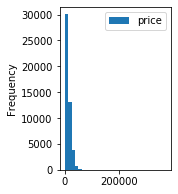

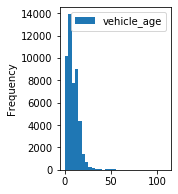

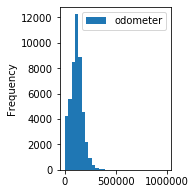

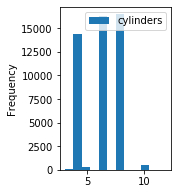

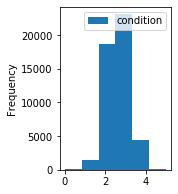




WITHOUT OUTLIERS


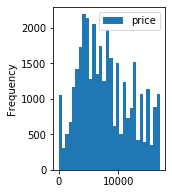

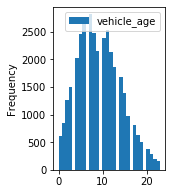

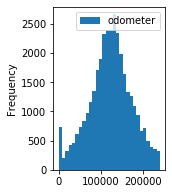

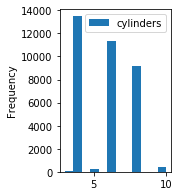

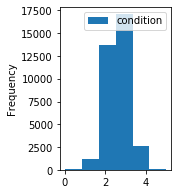

In [13]:
# -------
# HISTOGRAMS
print_histograms()

WITH OUTLIERS


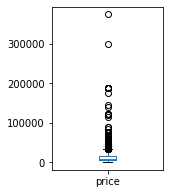

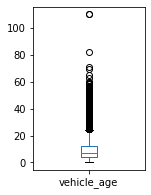

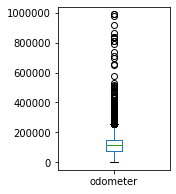

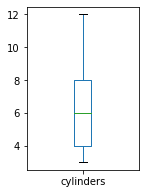

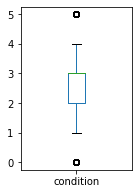




WITHOUT OUTLIERS


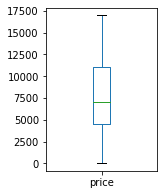

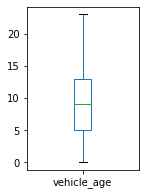

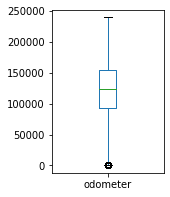

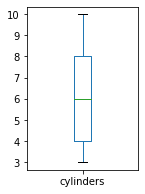

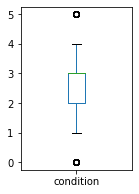

In [14]:
# -------
# BOXPLOTS
print_boxplots()

### Notes

- Histograms for price, vehicle_age, and odometer all show right skewed tendencies
- Boxplots for the same three categories show large numbers of outliers in the upper ranges
- We determined the upper limits for the same three (intentionally ignoring the lower outliers for the odometer category, as we were asked only to determine upper limits), and filtered out the outliers
- The resulting histograms exhibit tendencies much closer to normally distributed data; however:
    - Price has a multitude of intensive spikes
    - Odometer has one intense spike in the lowest region
    - No 12-cylinder cars survived the cull

In [15]:
# ----------
# STATS
def display_stats(data_original, data_filtered):
    print("STATISTICS - ORIGINAL")
    print(data_original['days_listed'].describe())
    print("\nSTATISTICS - FILTERED")
    print(data_filtered['days_listed'].describe())
    print("\n\nCORRELATION MATRIX - ORIGINAL")
    print(data_original.corr()['days_listed'])
    print("\nCORRELATION MATRIX - FILTERED")
    print(data_filtered.corr()['days_listed'])

display_stats(car_data, car_data_filtered)

STATISTICS - ORIGINAL
count    47905.000000
mean        39.564430
std         28.202122
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

STATISTICS - FILTERED
count    34664.000000
mean        39.681168
std         28.422788
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64


CORRELATION MATRIX - ORIGINAL
price                -0.002444
model_year           -0.005528
condition            -0.003013
cylinders             0.000192
odometer              0.003399
is_4wd                0.001985
days_listed           1.000000
day_of_the_week       0.002656
month                -0.010626
year                  0.009982
vehicle_age           0.006249
avg_yearly_mileage   -0.001875
Name: days_listed, dtype: float64

CORRELATION MATRIX - FILTERED
price                 0.006913
model_year            0.002147
cond

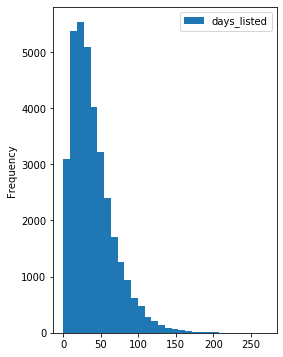

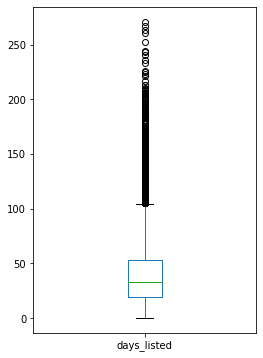

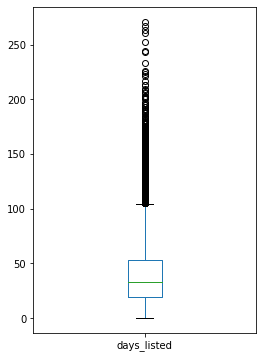

In [16]:
# ----------
# HISTOGRAMS
car_data_filtered.plot(kind='hist', y='days_listed', bins=30, figsize=(4,6))
plt.show()
car_data.plot(kind='box', y='days_listed', figsize=(4,6))
car_data_filtered.plot(kind='box', y='days_listed', figsize=(4,6))

STATISTICS - ORIGINAL
count    47905.000000
mean        39.564430
std         28.202122
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

STATISTICS - FILTERED
count    6004.000000
mean        8.914724
std         3.635581
min         0.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        14.000000
Name: days_listed, dtype: float64


CORRELATION MATRIX - ORIGINAL
price                -0.002444
model_year           -0.005528
condition            -0.003013
cylinders             0.000192
odometer              0.003399
is_4wd                0.001985
days_listed           1.000000
day_of_the_week       0.002656
month                -0.010626
year                  0.009982
vehicle_age           0.006249
avg_yearly_mileage   -0.001875
Name: days_listed, dtype: float64

CORRELATION MATRIX - FILTERED
price                -0.010494
model_year            0.013463
condition   

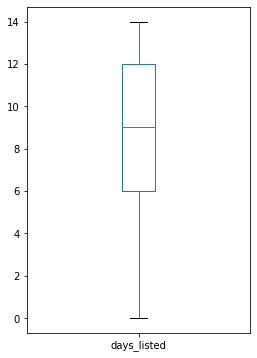

In [17]:
# ----------
# FAST REMOVAL
car_data_filtered_fast_removal = car_data_filtered.query('days_listed < 15')
display_stats(car_data, car_data_filtered_fast_removal)
car_data_filtered_fast_removal.plot(kind='box', y='days_listed', figsize=(4,6))

STATISTICS - ORIGINAL
count    47905.000000
mean        39.564430
std         28.202122
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

STATISTICS - FILTERED
count     80.000000
mean     193.750000
std       25.324477
min      168.000000
25%      175.750000
50%      184.000000
75%      202.250000
max      271.000000
Name: days_listed, dtype: float64


CORRELATION MATRIX - ORIGINAL
price                -0.002444
model_year           -0.005528
condition            -0.003013
cylinders             0.000192
odometer              0.003399
is_4wd                0.001985
days_listed           1.000000
day_of_the_week       0.002656
month                -0.010626
year                  0.009982
vehicle_age           0.006249
avg_yearly_mileage   -0.001875
Name: days_listed, dtype: float64

CORRELATION MATRIX - FILTERED
price                -0.135824
model_year            0.084736
condition           

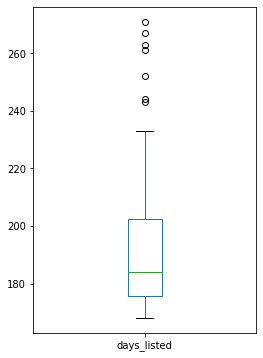

In [18]:
# ----------
# SLOW & REALLY SLOW REMOVAL
car_data_filtered_slow_removal = car_data_filtered.query('days_listed >= 79.5') # >= 53 * 1.5
car_data_filtered_really_slow_removal = car_data_filtered.query('days_listed >= 168') # >= 112 * 1.5
display_stats(car_data, car_data_filtered_really_slow_removal)
car_data_filtered_really_slow_removal.plot(kind='box', y='days_listed', figsize=(4,6))

### Notes

- Statistics for days_listed
    - There is no marked difference between the original and the filtered data
    - Mean = approx. 40 days
    - Median = 33 days
- There is no obvious connection between duration of listing and any other parameters
    - Fast removal has very low correlation coefficients with all other parameters (including with up to a 15 day threshhold as being considered "fast" when it is roughly half the median)
    - Slow removal tells a similar story
        - Even when looking at the outliers among the outliers (i.e., those up for longer the 168 days), there are no strong correlations found

- This seems to indicate that there is no connection between duration of listing and any other parameter

             count         mean
             price        price
type                           
sedan        10857  6735.120475
SUV           9112  8100.839991
truck         6111  9636.184422
pickup        3328  8944.275841
wagon         1236  7902.990291
coupe         1125  7254.829333
mini-van       960  6890.446875
hatchback      907  6552.830209
van            497  7452.613682
convertible    229  9202.655022
other          183  8236.508197
offroad        112  9846.892857
bus              7  5767.857143


Text(0, 0.5, 'Number of Ads')

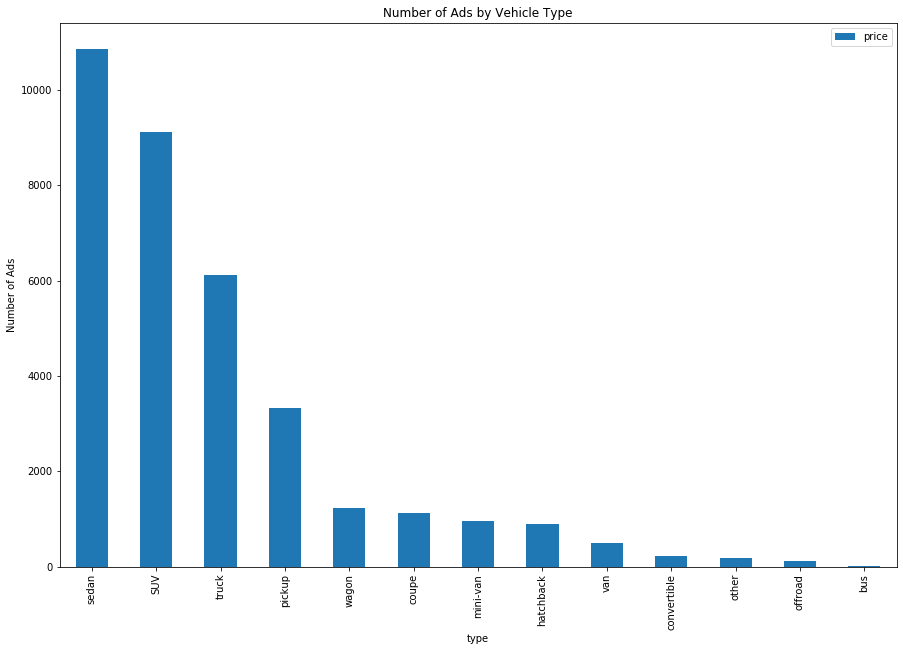

In [26]:
# DETERMINE TWO MOST ADVERTISED MODELS
ads_by_types = pd.pivot_table(car_data_filtered, index='type', values='price', aggfunc=['count','mean'])
ads_by_types = ads_by_types.reindex(ads_by_model['count'].sort_values(by='price', ascending=False).index)
assert len(ads_by_types) == len(car_data_filtered['type'].unique()), "Quantity error: wrong number of types"

print(ads_by_types)
ads_by_types.plot.bar(y='count', figsize=(15,10), title='Number of Ads by Vehicle Type')
plt.ylabel('Number of Ads')


### Notes

- The two types of vehicles with the greatest number of ads are:
    - Sedan
    - SUV

In [27]:
# ------
# DETERMINE FACTORS THAT IMPACT PRICE THE MOST
sedan_data = car_data_filtered.query("type == 'sedan'")
suv_data = car_data_filtered.query("type == 'SUV'")
assert len(sedan_data) == 10857, "Quantity error: wrong number of ads" # number of ads found in previous section
assert len(suv_data) == 9112, "Quantity error: wrong number of ads" # number of ads found in previous section
print("Sedan")
print(sedan_data.corr()['price'])
print("\n\nSUV")
print(suv_data.corr()['price'])

Sedan
price                 1.000000
model_year            0.639140
condition             0.262201
cylinders            -0.110613
odometer             -0.522009
is_4wd               -0.003630
days_listed          -0.005440
day_of_the_week      -0.010735
month                -0.023165
year                  0.015288
vehicle_age          -0.635784
avg_yearly_mileage    0.300904
Name: price, dtype: float64


SUV
price                 1.000000
model_year            0.484395
condition             0.188922
cylinders            -0.117784
odometer             -0.327579
is_4wd                0.045213
days_listed           0.006040
day_of_the_week       0.017737
month                -0.008033
year                 -0.001334
vehicle_age          -0.482769
avg_yearly_mileage    0.301862
Name: price, dtype: float64


In [28]:
# ------
# PLOTS
def find_under_50(data, category):
    index = data[category].value_counts().index
    num_ads_by_category = data[category].value_counts()
    return [x for x in index if num_ads_by_category[x] < 50]

# Tests for find_under_50()
for x in find_under_50(sedan_data, 'paint_color'):
    assert x in ['orange', 'yellow', 'purple'], "Membership error: not in proper subset"
for x in find_under_50(suv_data, 'paint_color'):
    assert x in ['yellow', 'purple'], "Membership error: not in proper subset"
for x, y in zip(find_under_50(sedan_data, 'transmission'), find_under_50(suv_data, 'transmission')):
    assert x and y in ['manual', 'other'], "Membership error: not in proper subset"


def print_boxplots(data, col_to_filter, title):
    # paint_color
    data_filtered = data[~(data[col_to_filter].isin(find_under_50(data, col_to_filter)))]
    data_filtered.boxplot(column='price', by=col_to_filter, figsize=(4,6))
    plt.xticks(rotation=90)
    plt.ylabel('price')
    plt.title(title)
    plt.suptitle('')
    

def print_scatterplots(data, x_axis, title):
    data.plot(x=x_axis, y='price', kind='scatter', alpha=0.2)
    plt.title(title)

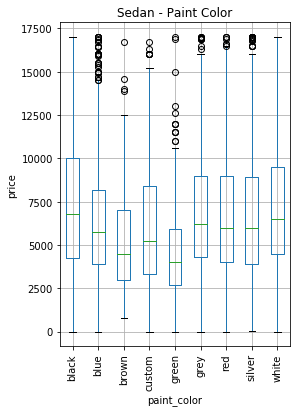

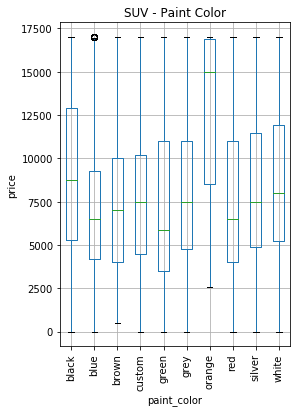

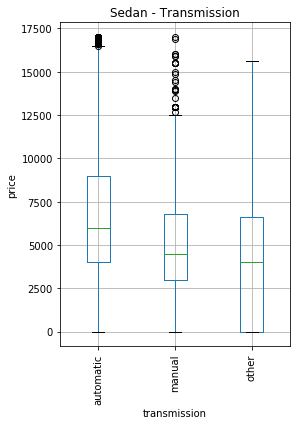

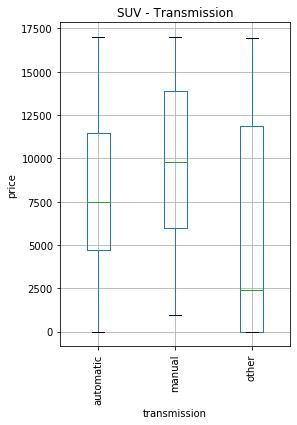

In [29]:
# ---------
# CATEGORICAL
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

print_boxplots(sedan_data, 'paint_color', 'Sedan - Paint Color')
print_boxplots(suv_data, 'paint_color', 'SUV - Paint Color')
print_boxplots(sedan_data, 'transmission', 'Sedan - Transmission')
print_boxplots(suv_data, 'transmission', 'SUV - Transmission')

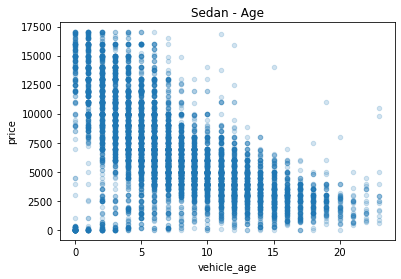

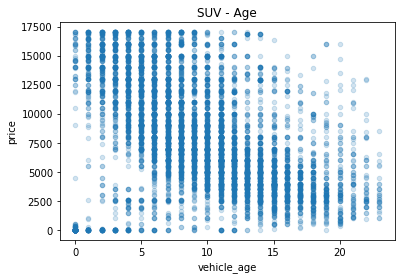

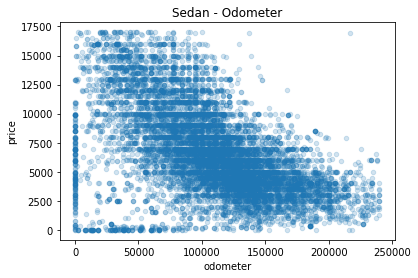

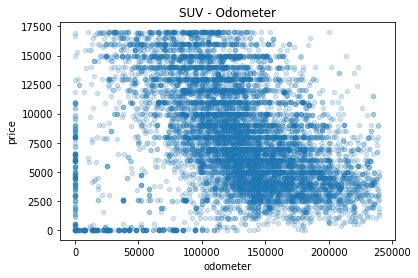

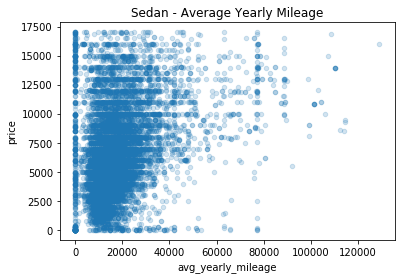

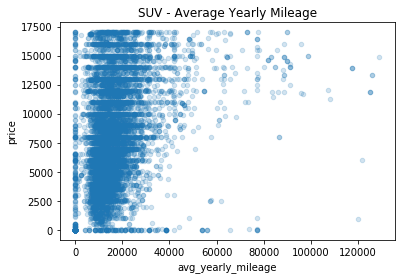

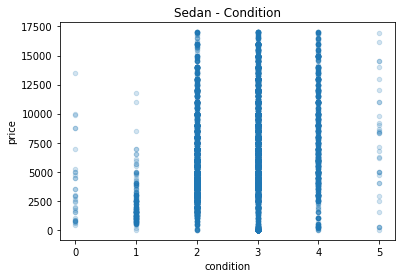

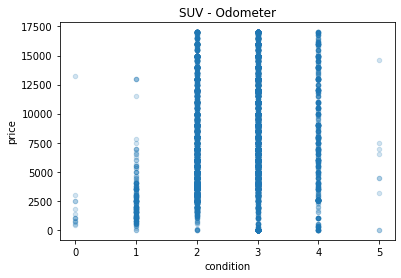

In [30]:
# ---------
# NUMERICAL
print_scatterplots(sedan_data, 'vehicle_age', 'Sedan - Age')
print_scatterplots(suv_data, 'vehicle_age', 'SUV - Age')
print_scatterplots(sedan_data, 'odometer', 'Sedan - Odometer')
print_scatterplots(suv_data, 'odometer', 'SUV - Odometer')
print_scatterplots(sedan_data, 'avg_yearly_mileage', 'Sedan - Average Yearly Mileage')
print_scatterplots(suv_data, 'avg_yearly_mileage', 'SUV - Average Yearly Mileage')
print_scatterplots(sedan_data, 'condition', 'Sedan - Condition')
print_scatterplots(suv_data, 'condition', 'SUV - Odometer')

### Notes

- For the sedan
    - The most impactful factors appear to be (in descending order):
        - model_year (0.639)
        - vehicle_age (-0.636)
        - odometer (-0.522)
        - avg_yearly_mileage (0.301)
        - condition (0.262)
- For the SUV
    - The most impactful factors appear to be (in descending order):
        - model_year (0.484)
        - vehicle_age (-0.483)
        - odometer (-0.328)
        - avg_yearly_mileage (0.301)
        - condition (0.189)

- The first two (model_year & vehicle_age) are in essence the same and by far the strongest indicators of price
- Paint color appears to have different effects on the price
    - Sedan purchasers appear to prefer black & white to green & brown, but the data appear to show little dispersion
    - SUV buyers appear to strongly favor orange, with a much higher median & interquartile range than other colors
- Transmission appears to have a small effect on the price
    - Sedans with automatic transmissions tend to fetch higher prices
    - SUVs with manual transmissions tend to fetch higher prices
    - Other transmissions possibly include unlabelled vehicles and might affect this, however
        - Though other transmissions may exist (e.g., paddles), those tend to be less prevalent in consumer cars and thus, the data more likely contain unclassified automatic and manual transmissions instead, making this category of limited use in our analysis

<a id='section_4'></a>

# Section 4: General Conclusion

The strongest predictor for price appears to be the vehicle's age first and foremost: as the vehicle ages, its value decreases. 

The overall mileage has a strong negative correspondence with price: as mileage goes up, price goes down. Oddly enough, the average yearly mileage has a surprising, positive correspondence that, though weakly so, as the average yearly mileage increases, so does the price. 

The paint color has a very limited and specific effect unique to each type. Whereas sedan purchasers tend to prefer black & white, SUV buyers are more attracted to orange.

Finally, the condition also appears to affect the price to a limited extent with vehicle conditions < 2 almost always yielding lower prices.